# Deep Gaussian Processes
## Introduction

In this notebook, we provide a GPyTorch implementation of deep Gaussian processes, where training and inference is performed using the method of Salimbeni et al., 2017 (https://arxiv.org/abs/1705.08933) adapted to CG-based inference.

We'll be training a simple two layer deep GP on the `elevators` UCI dataset.

In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm.notebook 
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood


env: CUDA_VISIBLE_DEVICES=0


In [2]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

import urllib.request
import os
from scipy.io import loadmat
from math import floor
### Loading Data

For this example notebook, we'll be using the `elevators` UCI dataset used in the paper. Running the next cell downloads a copy of the dataset that has already been scaled and normalized appropriately. For this notebook, we'll simply be splitting the data using the first 80% of the data as training and the last 20% as testing.

**Note**: Running the next cell will attempt to download a ~400 KB dataset file to the current directory.

In [3]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor


In [4]:
torch.cuda.empty_cache()

In [4]:


# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)


if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(1000, 3), torch.randn(1000)
else:
    data = torch.Tensor(loadmat('/work/sghoshstat/ywu39393/Research/Deep_gp_template/elevators.mat')['data'])
    X = data[:, :-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]


train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [5]:
from sklearn.model_selection import train_test_split
drug_std = torch.load('drug_y_std')
drug_mean = torch.load('drug_y_mean')
gene_std = torch.load('gene_y_std')
gene_mean = torch.load('gene_y_mean')
full_y = torch.load('test_y_full').reshape(-1)

#calculate the mean value of drug and gene predict
train_x_stack = torch.stack((drug_mean, gene_mean), dim=1)

train_x, test_x, train_y, test_y = train_test_split(train_x_stack, full_y, test_size=0.2, random_state=42)

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [6]:
train_x.shape

torch.Size([13852, 2])

In [7]:
train_y.shape

torch.Size([13852])

In [8]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Defining GP layers

In GPyTorch, defining a GP involves extending one of our abstract GP models and defining a `forward` method that returns the prior. For deep GPs, things are similar, but there are two abstract GP models that must be overwritten: one for hidden layers and one for the deep GP model itself.

In the next cell, we define an example deep GP hidden layer. This looks very similar to every other variational GP you might define. However, there are a few key differences:

1. Instead of extending `ApproximateGP`, we extend `DeepGPLayer`.
2. `DeepGPLayers` need a number of input dimensions, a number of output dimensions, and a number of samples. This is kind of like a linear layer in a standard neural network -- `input_dims` defines how many inputs this hidden layer will expect, and `output_dims` defines how many hidden GPs to create outputs for.

In this particular example, we make a particularly fancy `DeepGPLayer` that has "skip connections" with previous layers, similar to a ResNet.

In [9]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))

## Building the deep GP

Now that we've defined a class for our hidden layers and a class for our output layer, we can build our deep GP. To do this, we create a `Module` whose forward is simply responsible for forwarding through the various layers.

This also allows for various network connectivities easily. For example calling,
```
hidden_rep2 = self.second_hidden_layer(hidden_rep1, inputs)
```
in forward would cause the second hidden layer to use both the output of the first hidden layer and the input data as inputs, concatenating the two together.

In [10]:

class DeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=2,
            mean_type='linear',
        )
        hidden_layer2 = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=2,
            mean_type='linear',
        )
        hidden_layer3 = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer2.output_dims,
            output_dims=2,
            mean_type='linear',
        )
        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer3.output_dims,
            output_dims=None,
            mean_type='constant',
        )
        
        super().__init__()
        
        self.hidden_layer = hidden_layer
        self.hidden_layer2 = hidden_layer2
        self.hidden_layer3 = hidden_layer3
        self.last_layer = last_layer
        self.likelihood = GaussianLikelihood()
    
    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        hidden_rep2 = self.hidden_layer2(hidden_rep1)
        hidden_rep3 = self.hidden_layer3(hidden_rep2)
        output = self.last_layer(hidden_rep3)
        return output
    
    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))
        
        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [11]:
model = DeepGP(train_x.shape)
if torch.cuda.is_available():
    model = model.cuda()

## Objective function (approximate marginal log likelihood/ELBO)

Because deep GPs use some amounts of internal sampling (even in the stochastic variational setting), we need to handle the objective function (e.g. the ELBO) in a slightly different way. To do this, wrap the standard objective function (e.g. `~gpytorch.mlls.VariationalELBO`) with a `gpytorch.mlls.DeepApproximateMLL`.

## Training/Testing

The training loop for a deep GP looks similar to a standard GP model with stochastic variational inference.

In [12]:
# this is for running the notebook in our testing framework
num_epochs = 100
num_samples = 50


optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, train_x.shape[-2]))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/217 [00:00<?, ?it/s]

The output distribution of a deep GP in this framework is actually a mixture of `num_samples` Gaussians for each output. We get predictions the same way with all GPyTorch models, but we do currently need to do some reshaping to get the means and variances in a reasonable form.

Note that you may have to do more epochs of training than this example to get optimal performance; however, the performance on this particular dataset is pretty good after 10.

In [13]:
import gpytorch
import math



test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024)

model.eval()
predictive_means, predictive_variances, test_lls = model.predict(test_loader)

rmse = torch.mean(torch.pow(predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")

RMSE: 0.061513762921094894, NLL: -1.3674180507659912


In [14]:
test_y.shape

torch.Size([3464])

In [15]:
predictive_means.mean(0).shape

torch.Size([3464])

In [16]:
from matplotlib import pyplot as plt

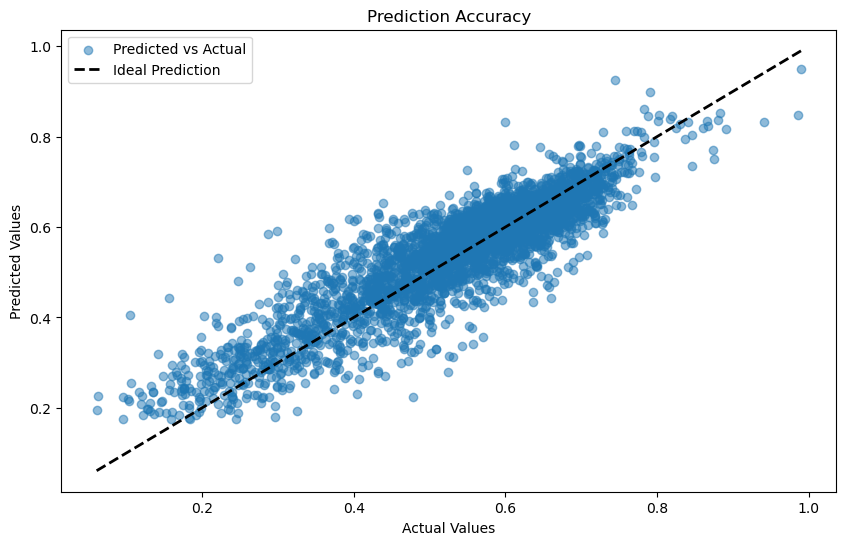

In [17]:
predict_value= predictive_means.mean(0).cpu().numpy()
test_y2 = test_y.cpu().numpy()
plt.figure(figsize=(10, 6))
plt.scatter(test_y2, predict_value, alpha=0.5, label='Predicted vs Actual')

# Line plot for the perfect predictions
max_val = max(test_y2.max(), predict_value.max())
min_val = min(test_y2.min(), predict_value.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Accuracy')
plt.legend()
plt.savefig('DGP_combine.jpg')

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
#MAE
score_MAE = mean_absolute_error(predict_value, test_y2)
print("The Mean Absolute Error of our Model is {}".format(round(score_MAE, 4)))

#r^2
score = r2_score(predict_value, test_y2)
print("The R square of our model is {}%".format(round(score, 4)))
# RMSE 
score_rmse = np.sqrt(mean_absolute_error(predict_value, test_y2))
print("The Mean Absolute Error of our Model is {}".format(round(score_rmse, 4)))


The Mean Absolute Error of our Model is 0.04600000008940697
The R square of our model is 0.7561%
The Mean Absolute Error of our Model is 0.21439999341964722
